In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image
import cv2
import albumentations as A
import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 7.5 MB/s eta 0:00:00


In [2]:
from segmentation_models_pytorch.losses import FocalLoss

In [3]:
IMAGE_PATH = '/kaggle/input/floodnet-cropresized-512-wpartialmasks/image/'
MASK_PATH = '//kaggle/input/floodnet-cropresized-512-wpartialmasks/mask/'

In [4]:
n_classes = 11 

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  398


In [5]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.05, random_state=786)
X_train, X_val = train_test_split(X_trainval, test_size=0.08, random_state=786)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  347
Val Size     :  31
Test Size    :  20


Image Size (512, 512, 3)
Mask Size (512, 512)


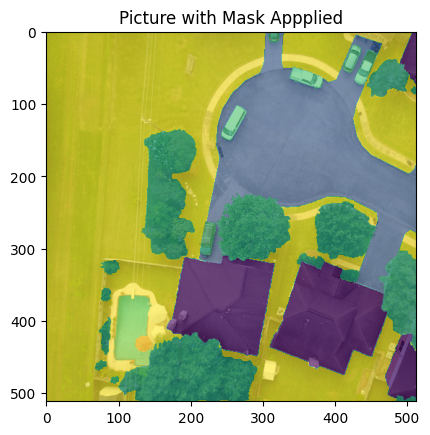

In [6]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.png')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)
plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [7]:
class FloodNetDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        else:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        return img, mask

In [8]:
class Config:
    IMAGE_SIZE = (512, 512)
    BATCH_SIZE = 8 
    NUM_CLASSES = 11
    LEARNING_RATE = 0.00012
    NUM_EPOCHS = 30
    ENCODER = 'timm-efficientnet-b0' #'resnet34' 'timm-efficientnet-b0'
    WEIGHTS = 'imagenet'
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.HorizontalFlip(),A.VerticalFlip(),A.RandomBrightnessContrast((0,0.2),(0,0.2))])
t_val = A.Compose([A.HorizontalFlip(),A.VerticalFlip(),A.RandomBrightnessContrast((0,0.2),(0,0.2))])

#datasets
train_set = FloodNetDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train)
val_set = FloodNetDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val)

train_loader = DataLoader(train_set, batch_size=Config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=Config.BATCH_SIZE, shuffle=True) 

In [10]:
model = smp.DeepLabV3Plus(
    encoder_name=Config.ENCODER,       
    encoder_weights=Config.WEIGHTS,   
    in_channels=3,               
    classes=Config.NUM_CLASSES,    
)


model = model.to(Config.DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 40.6MB/s]


In [11]:
criterion = FocalLoss(mode="multiclass", ignore_index=255)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)

In [13]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0

    for images, masks in loader:
        images, masks = images.to(Config.DEVICE), masks.to(Config.DEVICE)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(Config.DEVICE), masks.to(Config.DEVICE)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            total_loss += loss.item()

    return total_loss / len(loader)

import matplotlib.colors as mcolors

import random
def generate_random_colors(num_classes):
    colors = []
    for _ in range(num_classes):
        colors.append(tuple(random.randint(0, 255) for _ in range(3)))
    return colors
    
#class_colors = generate_random_colors(Config.NUM_CLASSES)

class_colors = []
class_colors.append(  (0, 0, 0)  ) #  Black for Background 
class_colors.append(  (102, 102, 0)  ) #  Dark Brown for Building Flooded
class_colors.append(  (204, 204, 0)  ) #  Light Brown for Building Non-Flooded
class_colors.append(  (96, 96, 96)  ) #  Dark Grey for Road Flooded
class_colors.append(  (160, 160, 160)  ) #  Grey for Road Non-Flooded
class_colors.append(  (153, 204, 255)  ) #  Blue for Water 
class_colors.append(  (0, 153, 76)  ) #  Dark Green for Tree
class_colors.append(  (255, 51, 51)  ) #  Red for Vehicle
class_colors.append(  (0, 128, 255)  ) #  Dark Blue for Pool
class_colors.append(  (153, 255, 51)  ) #  Light Green for Grass
#class_colors.append(  (255, 255, 255)  ) #  White for Ulabelled

class_colors_dict = {i: class_colors[i] for i in range(Config.NUM_CLASSES - 1)}
class_colors_dict[255] = (255, 255, 255)  # White for Ulabelled, Set specific color for ignore class

def visualize_predictions(model, loader, device, num_samples=3):
    model.eval()
    samples_shown = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)

            for i in range(images.size(0)):
                if samples_shown >= num_samples:
                    return

                image = images[i].cpu().permute(1, 2, 0).numpy()
                mask = masks[i].cpu().numpy()
                prediction = predictions[i].cpu().numpy()

                image = (image - image.min()) / (image.max() - image.min())

                mask_color = np.zeros((*mask.shape, 3), dtype=np.uint8)
                pred_color = np.zeros((*prediction.shape, 3), dtype=np.uint8)

                for label, color in class_colors_dict.items():
                    mask_color[mask == label] = color
                    pred_color[prediction == label] = color

                plt.figure(figsize=(9, 3))
                plt.subplot(1, 3, 1)
                plt.title("Input Image")
                plt.imshow(image)
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.title("Ground Truth")
                plt.imshow(mask_color)
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.title("Prediction")
                plt.imshow(pred_color)
                plt.axis("off")

                plt.show()
                samples_shown += 1

def plot_training_curve(train_losses, val_losses):
    plt.figure(figsize=(6, 3))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curve")
    plt.legend()
    plt.grid()
    plt.show()

# DeepLabV3+

Epoch 1/30
Training Loss: 1.3644
Validation Loss: 0.9821
36.48566746711731  sec per epoch
Visualizing predictions on validation set after Epoch 1


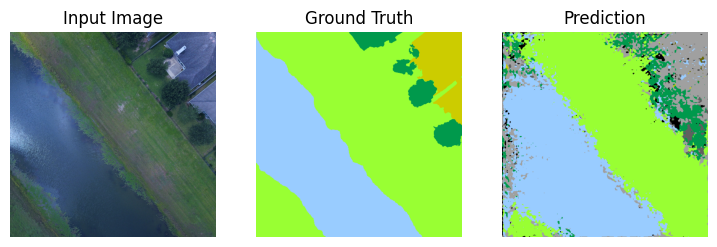

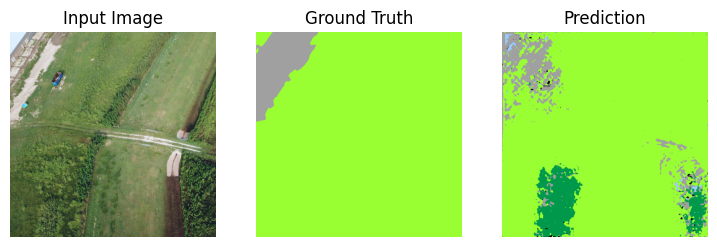

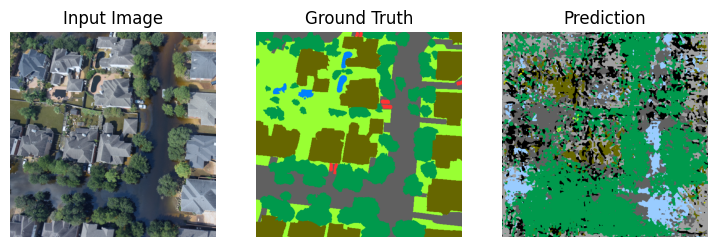

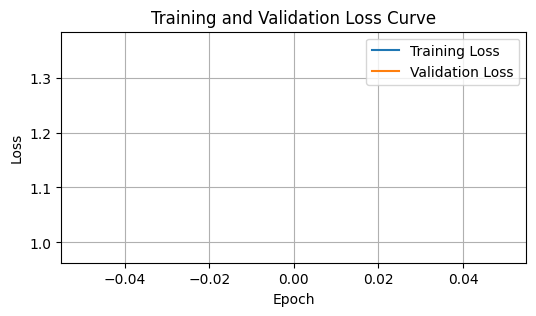

Epoch 2/30
Training Loss: 0.6890
Validation Loss: 0.4975
31.93540382385254  sec per epoch
Epoch 3/30
Training Loss: 0.4836
Validation Loss: 0.3564
32.09492778778076  sec per epoch
Epoch 4/30
Training Loss: 0.3787
Validation Loss: 0.2636
32.55855369567871  sec per epoch
Epoch 5/30
Training Loss: 0.3243
Validation Loss: 0.2323
32.8622841835022  sec per epoch
Visualizing predictions on validation set after Epoch 5


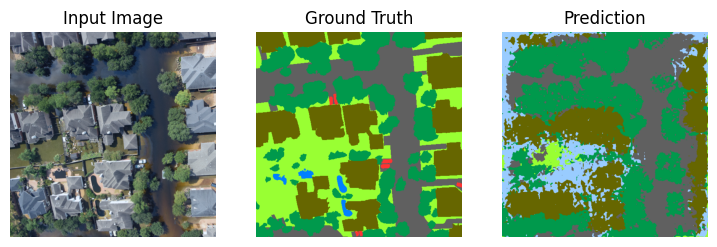

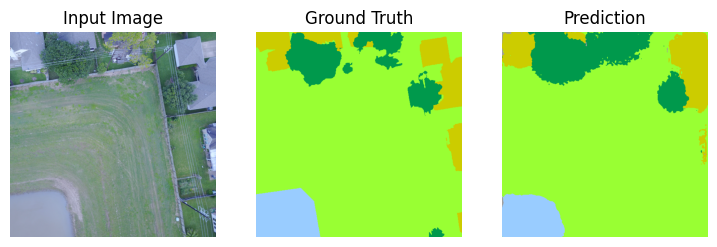

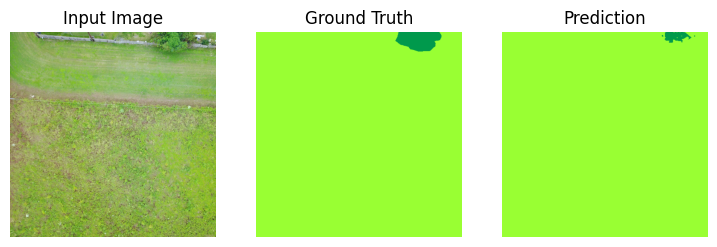

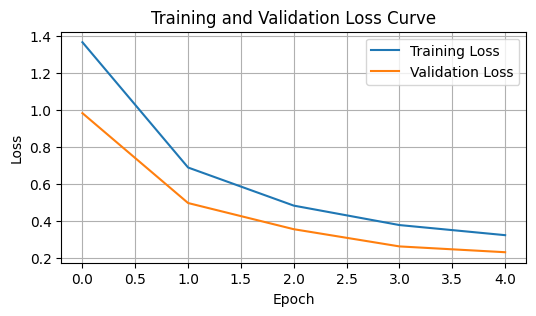

Epoch 6/30
Training Loss: 0.2884
Validation Loss: 0.2114
32.96296262741089  sec per epoch
Epoch 7/30
Training Loss: 0.2653
Validation Loss: 0.1921
33.02729892730713  sec per epoch
Epoch 8/30
Training Loss: 0.2399
Validation Loss: 0.1753
32.74740195274353  sec per epoch
Epoch 9/30
Training Loss: 0.2293
Validation Loss: 0.1657
32.739617586135864  sec per epoch
Epoch 10/30
Training Loss: 0.2109
Validation Loss: 0.1658
32.76118779182434  sec per epoch
Visualizing predictions on validation set after Epoch 10


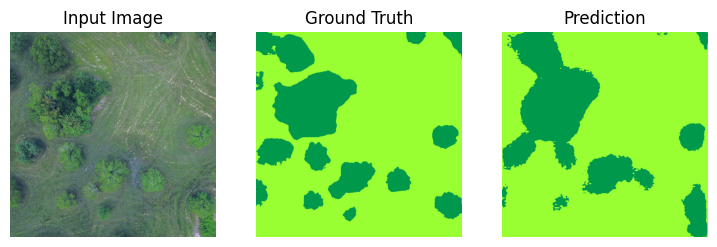

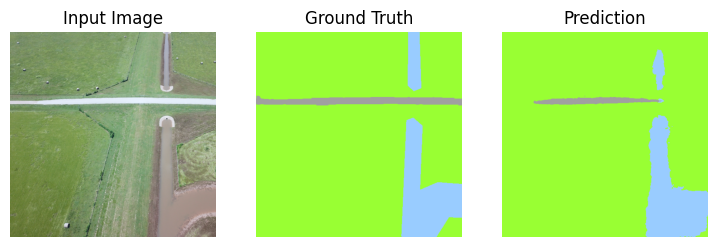

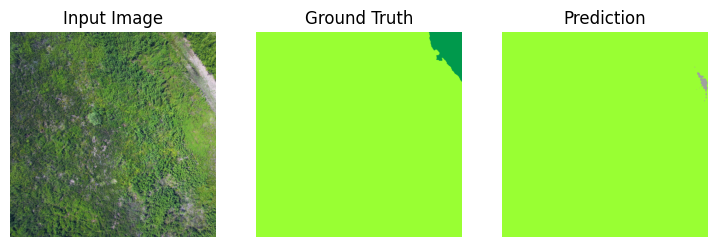

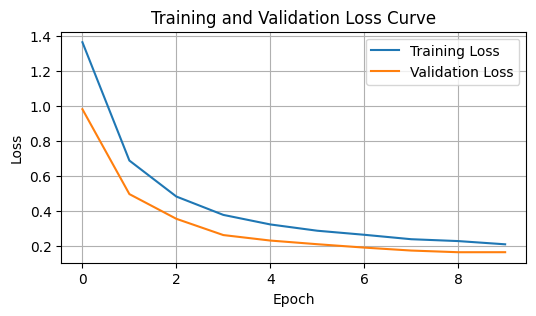

Epoch 11/30
Training Loss: 0.2055
Validation Loss: 0.1754
32.77409911155701  sec per epoch
Epoch 12/30
Training Loss: 0.1876
Validation Loss: 0.1568
32.70382356643677  sec per epoch
Epoch 13/30
Training Loss: 0.1774
Validation Loss: 0.1529
32.78325629234314  sec per epoch
Epoch 14/30
Training Loss: 0.1773
Validation Loss: 0.1560
32.74558472633362  sec per epoch
Epoch 15/30
Training Loss: 0.1620
Validation Loss: 0.1408
32.884905099868774  sec per epoch
Visualizing predictions on validation set after Epoch 15


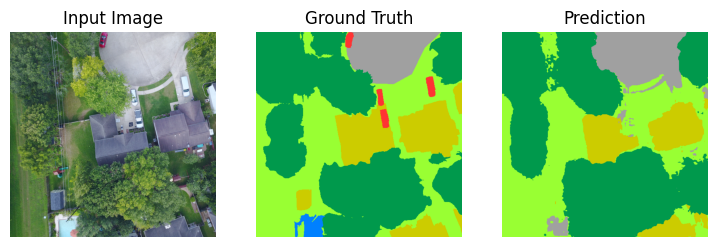

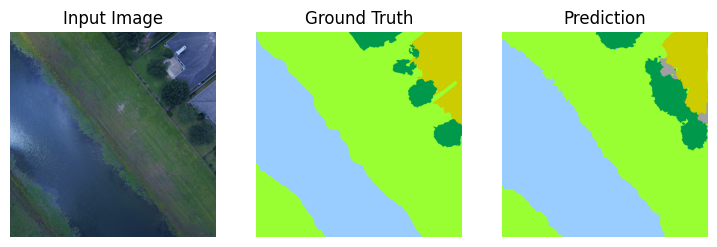

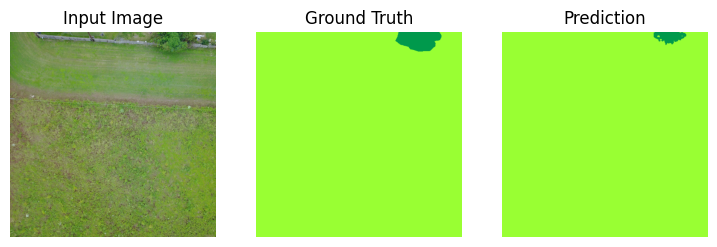

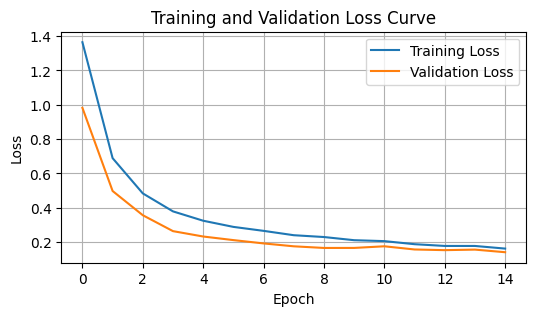

Epoch 16/30
Training Loss: 0.1599
Validation Loss: 0.1407
32.84648370742798  sec per epoch
Epoch 17/30
Training Loss: 0.1639
Validation Loss: 0.1587
32.80607628822327  sec per epoch
Epoch 18/30
Training Loss: 0.1604
Validation Loss: 0.1596
32.826738357543945  sec per epoch
Epoch 19/30
Training Loss: 0.1471
Validation Loss: 0.1329
32.8574538230896  sec per epoch
Epoch 20/30
Training Loss: 0.1472
Validation Loss: 0.1475
32.716461420059204  sec per epoch
Visualizing predictions on validation set after Epoch 20


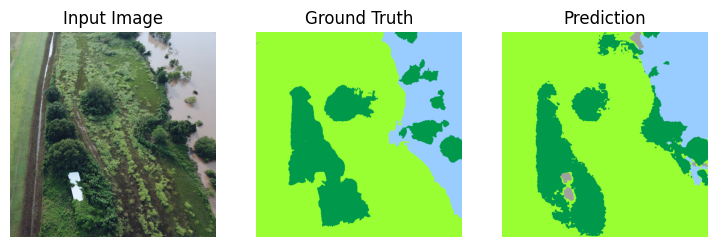

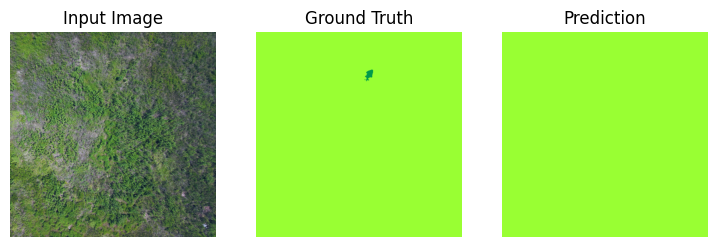

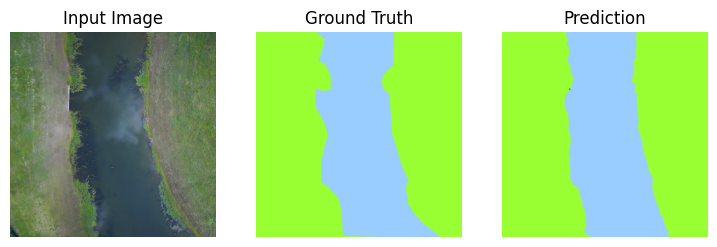

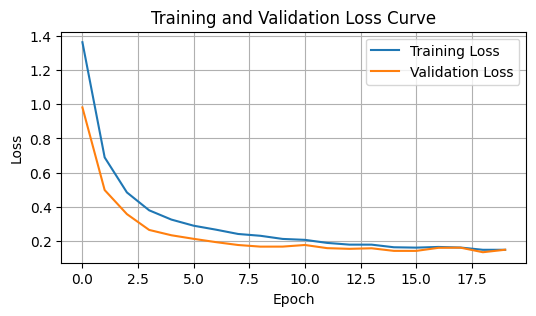

Epoch 21/30
Training Loss: 0.1352
Validation Loss: 0.1525
32.79553580284119  sec per epoch
Epoch 22/30
Training Loss: 0.1382
Validation Loss: 0.1490
32.7579071521759  sec per epoch
Epoch 23/30
Training Loss: 0.1483
Validation Loss: 0.1658
32.65202832221985  sec per epoch
Epoch 24/30
Training Loss: 0.1358
Validation Loss: 0.1458
32.8450984954834  sec per epoch
Epoch 25/30
Training Loss: 0.1312
Validation Loss: 0.1427
32.62134909629822  sec per epoch
Visualizing predictions on validation set after Epoch 25


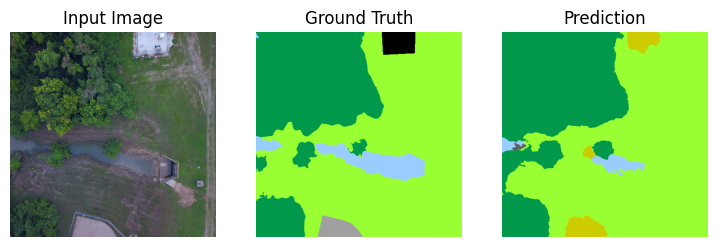

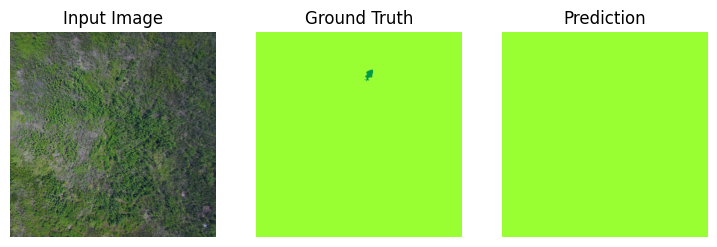

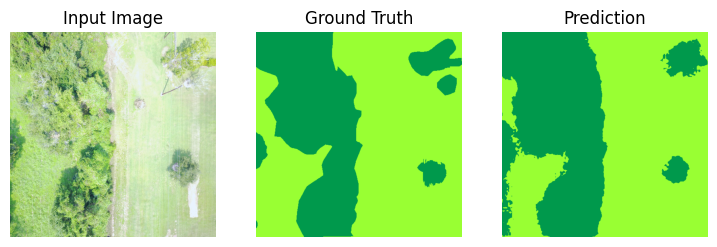

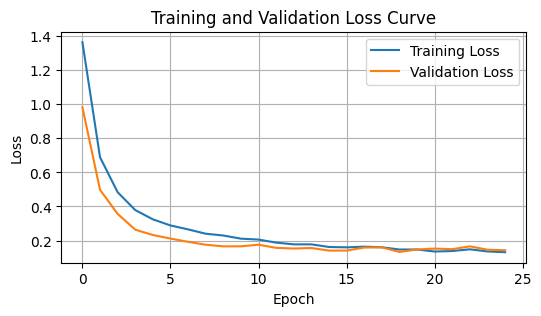

Epoch 26/30
Training Loss: 0.1303
Validation Loss: 0.1563
32.83215355873108  sec per epoch
Epoch 27/30
Training Loss: 0.1285
Validation Loss: 0.1415
32.72949576377869  sec per epoch
Epoch 28/30
Training Loss: 0.1180
Validation Loss: 0.1533
32.75683307647705  sec per epoch
Epoch 29/30
Training Loss: 0.1165
Validation Loss: 0.1480
32.6931836605072  sec per epoch
Epoch 30/30
Training Loss: 0.1115
Validation Loss: 0.1521
32.60057306289673  sec per epoch
Visualizing predictions on validation set after Epoch 30


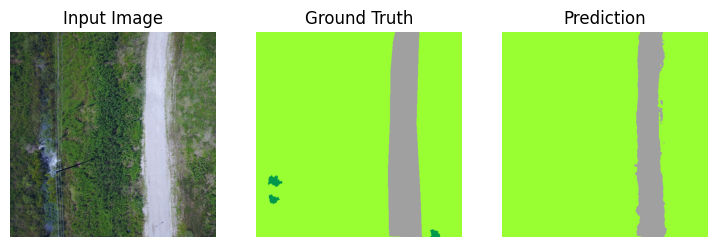

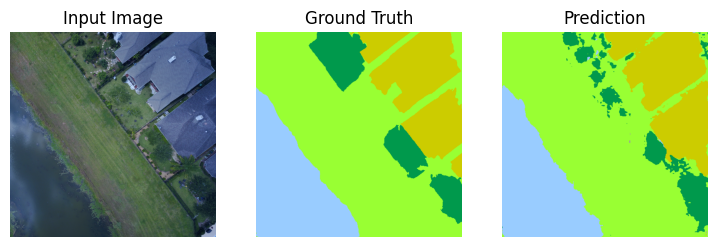

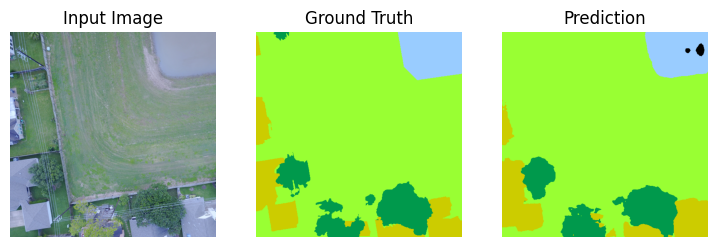

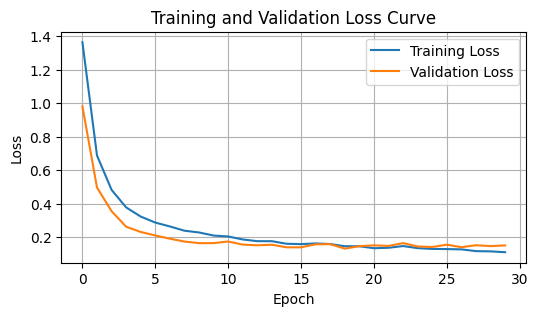

In [14]:
import time 

# Training loop
train_losses = []
val_losses = []

for epoch in range(Config.NUM_EPOCHS):
    tim = time.time()
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{Config.NUM_EPOCHS}")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")

    print(time.time()-tim,' sec per epoch')

    if (epoch + 1) % 5 == 0 or epoch == 0:  
        print(f"Visualizing predictions on validation set after Epoch {epoch+1}")
        visualize_predictions(model, val_loader, Config.DEVICE)

        plot_training_curve(train_losses, val_losses)

In [15]:
from torchvision.transforms import functional as TF

def predict_and_display(model, image_path, device):
    model.eval()
    with torch.no_grad():
        image = Image.open(image_path).convert("RGB")
        original_image = np.array(image)
        input_image = TF.to_tensor(image)
        input_image = TF.normalize(input_image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        input_image = input_image.unsqueeze(0).to(device)  # Add batch dimension

        output = model(input_image)
        prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

        pred_color = np.zeros((*prediction.shape, 3), dtype=np.uint8)
        for label, color in class_colors_dict.items():
            pred_color[prediction == label] = color

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Input Image")
        plt.imshow(original_image)
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title("Predicted Mask")
        plt.imshow(pred_color)
        plt.axis("off")

        plt.show()

In [16]:
def compute_dice_scores(model, images_list, masks_list, device, num_classes):
    model.eval()
    total_dice = 0
    dice_scores_list = []

    with torch.no_grad():
        for img_path, mask_path in zip(images_list, masks_list):

            image = Image.open(img_path).convert("RGB")
            input_image = TF.to_tensor(image)
            input_image = TF.normalize(input_image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            input_image = input_image.unsqueeze(0).to(device)

            mask = np.array(Image.open(mask_path))

            output = model(input_image)
            prediction = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

            dice_scores = []
            for cls in range(num_classes):
                pred_mask = (prediction == cls)
                gt_mask = (mask == cls)

                intersection = (pred_mask & gt_mask).sum()
                union = pred_mask.sum() + gt_mask.sum()

                if union > 0:
                    dice = 2 * intersection / union
                else:
                    dice = 1.0  # Perfect match if no pixels of this class exist

                dice_scores.append(dice)

            image_dice_score = np.mean(dice_scores)
            dice_scores_list.append(image_dice_score)
            total_dice += image_dice_score

    avg_dice = total_dice / len(images_list)
    return round(avg_dice,2), [round(d,2) for d in dice_scores_list]

In [17]:
images_list = ["/kaggle/input/floodnet-cropresized-512-wpartialmasks/image/"+str(num)+'.png' for num in list(X_test)]
masks_list = ["/kaggle/input/floodnet-cropresized-512-wpartialmasks/mask/"+str(num)+'.png' for num in list(X_test)]
avg_dice, dice_scores_list = compute_dice_scores(model, images_list, masks_list, Config.DEVICE, Config.NUM_CLASSES)
print(f"Average Dice Score: {avg_dice:.2f}")
print(dice_scores_list)

Average Dice Score: 0.86
[1.0, 0.96, 0.79, 0.77, 0.98, 0.85, 0.99, 0.63, 1.0, 0.87, 0.99, 0.72, 1.0, 0.88, 0.45, 0.99, 0.91, 0.49, 0.99, 0.98]


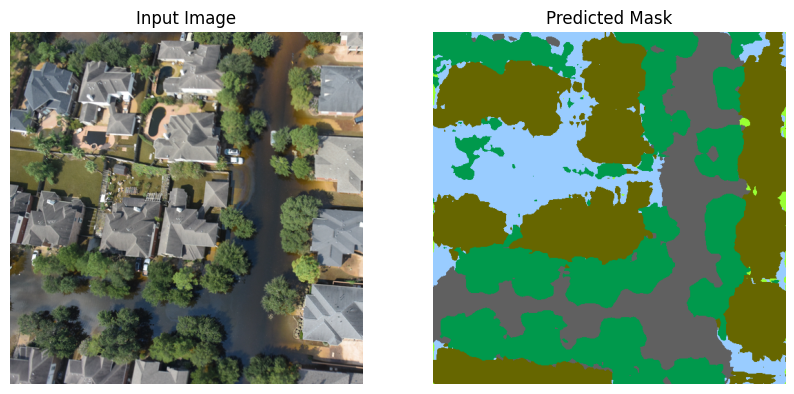

In [32]:
predict_and_display(model, "/kaggle/input/floodnet-cropresized-512-wpartialmasks/image/7488.png", Config.DEVICE)

In [19]:
torch.save(model.state_dict(), "unetpp_segmentation_normal2.pth")